In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
csv_path = '/content/drive/MyDrive/Dental_Disease_Predictions.csv'
image_base_path = '/content/drive/MyDrive/Dental Radiography Dataset'

# Load the CSV
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Clean column names

# Generate label dictionary from unique disease names
categories = sorted(df['Predicted Disease'].unique())
label_dict = {cat: idx for idx, cat in enumerate(categories)}
print("Label Dictionary:", label_dict)


Label Dictionary: {'Caries': 0, 'Impacted Teeth': 1, 'Normal': 2, 'Periodontitis': 3, 'Restorations': 4}


In [4]:
# Prepare image data and labels
img_size = 256
data = []
label = []

for index, row in df.iterrows():
    folder = row['Folder']
    filename = row['Filename']
    disease = row['Predicted Disease']
    full_path = os.path.join(image_base_path, folder, filename)

    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    try:
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            label.append(label_dict[disease])
        else:
            print(f"Could not read image: {full_path}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

In [5]:
# Convert to numpy arrays
data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
label = np.array(label)
new_label = to_categorical(label)

print("Data shape:", data.shape)
print("Label shape:", new_label.shape)

Data shape: (1269, 256, 256, 1)
Label shape: (1269, 5)


In [6]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.1)

In [7]:
# Define CNN model
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=(img_size, img_size, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Train
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - accuracy: 0.1989 - loss: 1.6730 - val_accuracy: 0.1878 - val_loss: 1.6095
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 290s 10s/step - accuracy: 0.2301 - loss: 1.6071 - val_accuracy: 0.2052 - val_loss: 1.6116
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 293s 10s/step - accuracy: 0.2414 - loss: 1.6058 - val_accuracy: 0.2009 - val_loss: 1.6332
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.2816 - loss: 1.5942 - val_accuracy: 0.1790 - val_loss: 1.6321
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 328s 10s/step - accuracy: 0.3348 - loss: 1.5347 - val_accuracy: 0.1572 - val_loss: 1.7066
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 318s 10s/step - accuracy: 0.4744 - loss: 1.3510 - val_accuracy: 0.1528 - val_loss: 2.0867
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 322s 10s/step - accuracy: 0.6064 - loss: 0.9761 - val_accuracy: 0.1790 - val_loss: 2.2408
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 322s 10s/step - accuracy: 0.7558 - loss: 0.6893 - val_accuracy: 0.

In [10]:
# Save model
model.save('/content/drive/MyDrive/model.h5')

In [11]:
# Evaluate
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2027 - loss: 4.1577
Test loss: 3.9965903759002686
Test accuracy: 0.21259842813014984


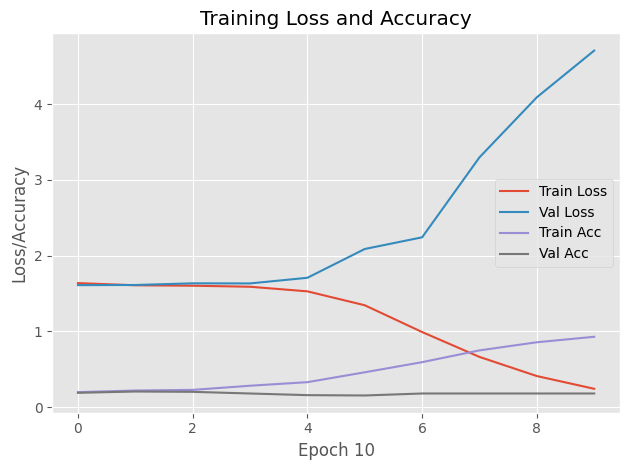

In [12]:
# Plot training history
plt.style.use("ggplot")
plt.figure()
N = len(history.history["loss"])
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Val Loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Val Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch 10")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
A.I predicts: Normal
Correct label is: Normal


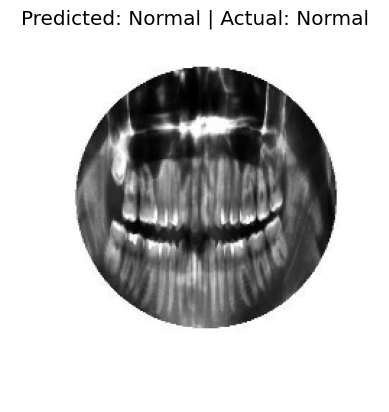

In [13]:
# Predict on a sample image
X = 32  # You can change index
img_single = x_test[X]
img_single = np.expand_dims(img_single, 0)  # Add batch dimension

predictions_single = model.predict(img_single)
predicted_label = np.argmax(predictions_single)
actual_label = np.argmax(y_test[X])

print("A.I predicts:", categories[predicted_label])
print("Correct label is:", categories[actual_label])

# Show image
plt.imshow(np.squeeze(img_single), cmap='gray')
plt.title(f"Predicted: {categories[predicted_label]} | Actual: {categories[actual_label]}")
plt.axis('off')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


<Figure size 640x480 with 0 Axes>

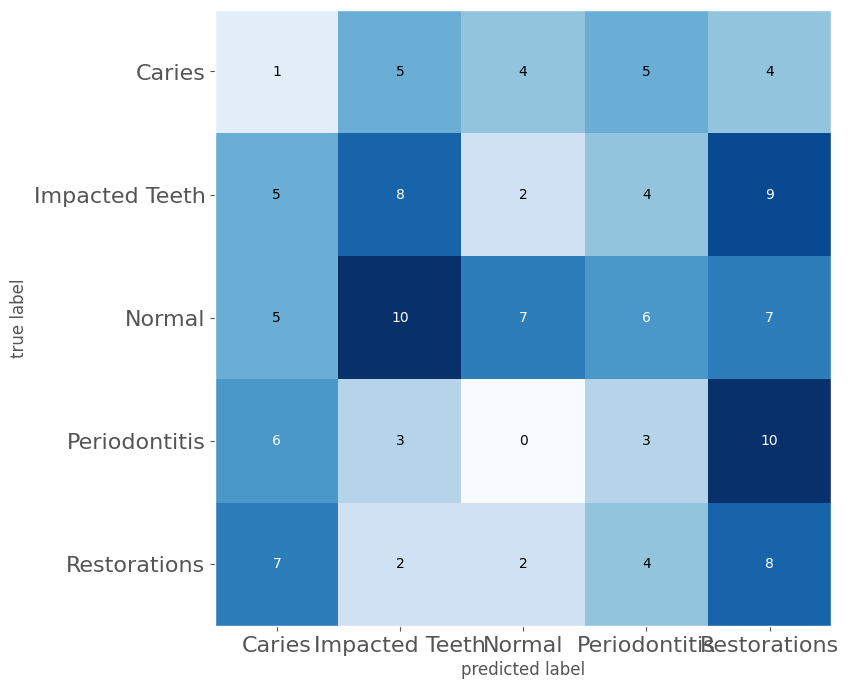

In [14]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(5), ['Caries','Impacted Teeth','Normal','Periodontitis','Restorations'], fontsize=16)
plt.yticks(range(5), ['Caries','Impacted Teeth','Normal','Periodontitis','Restorations'], fontsize=16)
plt.show()